# Define classes and consts

In [7]:
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from pathlib import Path
from typing import List, Dict
from os import listdir
from os.path import isfile, join
import re

In [19]:
LEAR_DATA_PATH = 'C:\my\study\IIAI\LB5\dataset_root'
TEST_DATA_PATH = 'C:\my\study\IIAI\LB5\input'
MODEL_INSTANCE_PATH = 'letter_recognition_cnn.pth'
CLASSES = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']      

In [35]:
class LetterRecognitionModel(nn.Module):
    def __init__(self):
        super(LetterRecognitionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 33)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ImageToModelFormatConverter:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ])
    
    def process_single_image(self, path: str):
        image = Image.open(path)
        return self.transform(image).unsqueeze(0)  # Add batch dimension 


    def process_folder(self, folder_path: str):
        return ImageFolder(root=folder_path, transform=self.transform)


class FromMultipleTestDataSet:
    def __init__(self):
        self.converter = ImageToModelFormatConverter()
        self.pattern = pattern = re.compile(r'(.+)\.(jpg|png)$', re.IGNORECASE)
    
    def form_dataset(self, root_path: str) -> Dict['str', Dict['str', List]]:
        multiple_data = {}

        dirs = [f for f in listdir(root_path) if not isfile(join(root_path, f))]
        

        for dir in dirs:
            data = {}
            path = join(root_path, dir)

            for file in listdir(path):
                if (match := self.pattern.match(file)):
                    name = match.group(1)
                    
                    if name not in data:
                        data[name] = []
                    
                    data[name] = self.converter.process_single_image(join(path, file))         

            multiple_data[dir] = data

        return multiple_data

# Model learn

In [20]:
converter = ImageToModelFormatConverter()

dataloader = DataLoader(converter.process_folder(LEAR_DATA_PATH), batch_size=32, shuffle=True)

model = LetterRecognitionModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), MODEL_INSTANCE_PATH)


Epoch 1/1000, Loss: 3.9297399520874023
Epoch 2/1000, Loss: 3.4354681968688965
Epoch 3/1000, Loss: 3.4955966472625732
Epoch 4/1000, Loss: 3.5137882232666016
Epoch 5/1000, Loss: 3.5932419300079346
Epoch 6/1000, Loss: 3.1176228523254395
Epoch 7/1000, Loss: 3.432298421859741
Epoch 8/1000, Loss: 3.301997661590576
Epoch 9/1000, Loss: 3.689493417739868
Epoch 10/1000, Loss: 3.709110736846924
Epoch 11/1000, Loss: 3.22175931930542
Epoch 12/1000, Loss: 3.864420175552368
Epoch 13/1000, Loss: 3.6477506160736084
Epoch 14/1000, Loss: 3.1740355491638184
Epoch 15/1000, Loss: 3.5396006107330322
Epoch 16/1000, Loss: 3.493462085723877
Epoch 17/1000, Loss: 3.4066147804260254
Epoch 18/1000, Loss: 3.6097311973571777
Epoch 19/1000, Loss: 3.6009299755096436
Epoch 20/1000, Loss: 3.5432238578796387
Epoch 21/1000, Loss: 3.427502393722534
Epoch 22/1000, Loss: 3.5471384525299072
Epoch 23/1000, Loss: 3.5354576110839844
Epoch 24/1000, Loss: 3.5452489852905273
Epoch 25/1000, Loss: 3.5119028091430664
Epoch 26/1000, Los

# Model testing

Actual: А Predicted: И Check: False
Actual: Б Predicted: З Check: False
Actual: В Predicted: В Check: True
Actual: З Predicted: У Check: False
Actual: И Predicted: Н Check: False
Actual: Х Predicted: К Check: False
Actual: Щ Predicted: Щ Check: True
Actual: Ь Predicted: Ь Check: True
Actual: Э Predicted: О Check: False


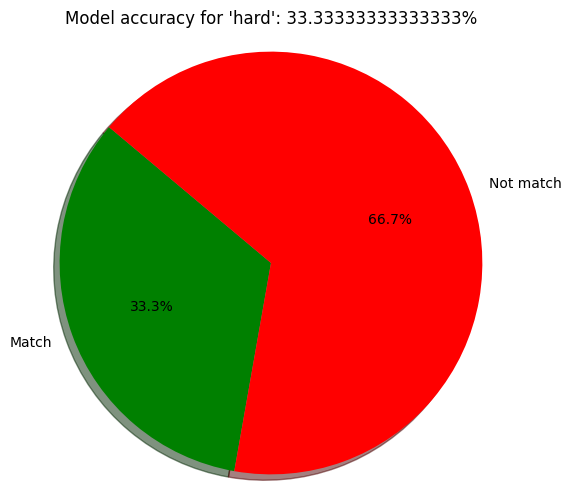

In [41]:
if 'model' not in locals():
    model = LetterRecognitionModel()


model.load_state_dict(torch.load(MODEL_INSTANCE_PATH))
model.eval()

tests_loader = FromMultipleTestDataSet()
used_data_set = 'hard'

count = 0
match = 0
for letter, data in tests_loader.form_dataset(TEST_DATA_PATH)[used_data_set].items():
    for test in data:

        with torch.no_grad():
            output = model(test)

        count += 1
        
        predicted_class = torch.argmax(output).item()

        predicted_class = torch.argmax(output).item()

        predicted_letter = CLASSES[predicted_class]
       
        match += 1 if predicted_letter == letter else 0 

        print(f"Actual: {letter} Predicted: {predicted_letter} Check: {letter==predicted_letter}")

import matplotlib.pyplot as plt

labels = 'Match', 'Not match'
sizes = [float(match)/count, float(count - match)/count]  # Percentages
colors = ['green', 'red']
explode = (0, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

plt.title(f"Model accuracy for '{used_data_set}': {float(match)/count*100}%")
plt.show()
